## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

import os
import time
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import Transformer, WarmUpThenDecay
from src.data_handling import read_first_n, sample_batch


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080, compute capability 8.9


In [3]:
def chunk_and_batch(corpus, chunk_size, batch_size, ):
    num_tokens = len(corpus)//chunk_size*chunk_size
    num_chunks = num_tokens//chunk_size

    steps_per_epoch = num_chunks//batch_size
    
    ds = tf.data.Dataset.from_tensor_slices(corpus)
    ds = ds.repeat()
    ds = ds.batch(chunk_size, drop_remainder=True)
    ds = ds.shuffle(buffer_size=100*chunk_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).repeat().prefetch(tf.data.AUTOTUNE)
    
    return ds, steps_per_epoch

In [4]:
max_seq_len = 1024

tokenizer = pkl.load(open("tokenizers/tokenizer_CNN16000_lowercase.pkl", 'rb'))
tokenizer.create_hash()
tokenizer.pre_merge_list = []
tokenizer.add_special_tokens(["<s>", "</s>"])
tokenizer.create_hash()

In [5]:
cut = 30235237//2

train_corpus = pkl.load(open('corpus/CNN_train_fused.pkl', 'rb'))[0]
test_corpus = pkl.load(open('corpus/CNN_test_fused.pkl', 'rb'))[0]

train_corpus = tf.concat([train_corpus, test_corpus[:cut]], axis=0)
test_corpus = test_corpus[cut:]

ds_train, steps_per_epoch  = chunk_and_batch(train_corpus, chunk_size=max_seq_len, batch_size=3)
ds_test, _ = chunk_and_batch(test_corpus, chunk_size=max_seq_len, batch_size=1)

In [6]:
print(steps_per_epoch)
print("Train corpus size: ", len(train_corpus))
print("Test corpus size: ", len(test_corpus))

43881
Train corpus size:  134803325
Test corpus size:  15117619


## Define Model

In [7]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 1024
embed_dim = 896
tf_blocks = 14
heads = 14
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    accum_steps=8,
                    )

losses_train = []
losses_test = []


In [9]:
name = "model_16k_CNN_yuge"


ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [9]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [10]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 150320072


In [11]:
def train_loop(iter_train, iter_test, steps_per_epoch, epochs):
    for i in tqdm(range(steps_per_epoch*epochs)):
        batch_train = next(iter_train)
        batch_test = next(iter_test)
        
        loss_train = model.train_step(batch_train).numpy()
        losses_train.append(loss_train)
        
        loss_test = model.evaluate(batch_test).numpy()
        losses_test.append(loss_test)

        if (i+1) % 1000 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(loss_train, loss_test, lr)
    return losses_train, losses_test

In [12]:
iter_train = iter(ds_train)
iter_test = iter(iter_train)

In [13]:
train_loop(iter_train, iter_test, steps_per_epoch, 3)

  0%|          | 0/131643 [00:00<?, ?it/s]

🔄 Tracing train_step; token shape: (None, None)
🔄 Tracing train_step; token shape: (None, None)
14.840654 15.037684 0.0
15.282411 15.195937 0.0
14.748656 15.193868 0.0
15.23812 15.18248 0.0
14.950511 15.320613 0.0
14.940202 15.165252 0.0
15.045801 15.271885 0.0
14.8310995 15.014384 1e-07
14.93185 15.091758 1e-07
14.965809 15.020949 1e-07
14.92372 15.052412 1e-07
15.09752 15.209582 1e-07
15.02003 15.01228 1e-07
14.835074 15.148035 1e-07
14.778823 14.962587 1e-07
14.756562 14.986536 2e-07
14.84562 14.915182 2e-07
15.029774 15.166984 2e-07
14.779714 15.064875 2e-07
14.993303 14.939669 2e-07
14.919806 15.122841 2e-07
14.877339 14.987004 2e-07
14.787253 15.022153 2e-07
14.941588 14.894953 2.9999998e-07
14.52015 15.092296 2.9999998e-07
14.946495 14.92852 2.9999998e-07
14.807931 15.01278 2.9999998e-07
14.775293 14.711388 2.9999998e-07
14.853199 15.175444 2.9999998e-07
14.717681 15.051641 2.9999998e-07
15.2193775 14.866321 2.9999998e-07
14.832954 14.936388 4e-07
14.96298 14.803876 4e-07
14.729

KeyboardInterrupt: 

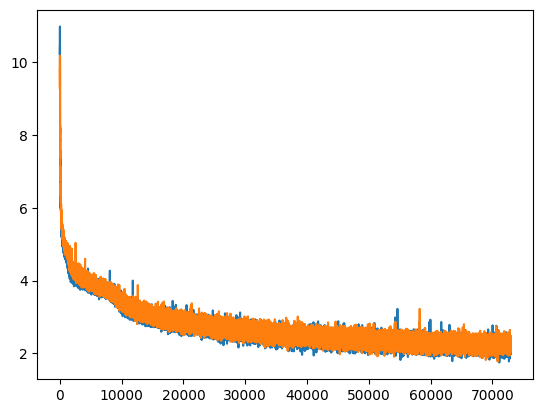

In [14]:
plt.plot(losses_test[100:], label="Test Loss")
plt.plot(losses_train[100:], label="Train Loss")

In [18]:
text = ""
text = text.lower()
SOS = tf.convert_to_tensor([[tokenizer.token_to_idx["<s>"]]])
indices = tf.cast(tokenizer.encode(text), tf.int32)
indices = tf.concat([SOS, indices], axis=1)
print(indices)

  0%|          | 0/16000 [00:00<?, ?it/s]

tf.Tensor([[16070]], shape=(1, 1), dtype=int32)


In [ ]:
import textwrap
import ipywidgets as widgets
from IPython.display import display

T = 1
tf.random.set_seed(42)
wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

for i in range(1024):
    logits = model.call(indices)[0, -1:]
    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    ) 
    indices = tf.concat([indices, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(indices)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:
        break

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2761, in while_loop
    while cond(*loop_vars):  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2753, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\functional_ops.py", line 655, in compute
    return (next_i, flat_a_out, tas)  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\functional_ops.py", line 650, in <listcomp>
    tas = [ta.write(i, value) for (ta, value) in zip(tas, flat_a_out)]  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\s

## 